In [171]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings

import pandas as pd
import numpy as np
import yfinance as yf

from pypfopt.expected_returns import ema_historical_return
from pypfopt.risk_models import exp_cov

from sklearn.preprocessing import PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

## Global Settings

In [90]:
seed = 1227
rs = np.random.RandomState(seed)

mpl.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)

warnings.filterwarnings('ignore')

sixteen_months_ago = (pd.to_datetime('today') - pd.DateOffset(months=16)).strftime('%Y-%m-%d')
five_years_sixteen_months_ago = (pd.to_datetime(sixteen_months_ago) - pd.DateOffset(years=5)).strftime('%Y-%m-%d')

sixteen_months_ago, five_years_sixteen_months_ago

('2021-10-28', '2016-10-28')

## Data

Our investment horizon is 16 months. We will choose the periodicity to be daily prices, using five years of historical daily closing prices as a starting point for portfolio optimization. For out of sample, we will use the last 16 months of data (counting from today) to evaluate the performance of the portfolio. This time frame is long enough to capture a variety of market conditions and reduce the impact of short-term fluctuations, but not so long that it becomes difficult to identify meaningful patterns or trends in the data.

In [91]:
# Create a list of symbols
symbols = [
  "XOM", "SHW", "JPM", "AEP", "UNH", "AMZN", "AAPL", "KO",
  "GOOGL", "GE", "SBUX", "PFE", "MSFT", "BA", "AMT",
  "DD", "JNJ", "TSN", "CVX", "SLG", "SPY", "VZ", "WMT", "TGT",
  "WFC", "PG", "DIS", "HD", "MCD", "IBM"
]
# Download data from Yahoo Finance for the last 5 years
asset_data = yf.download(
  tickers = symbols, 
  start = five_years_sixteen_months_ago
)['Adj Close']
# Examine the first 5 rows
asset_data.head(n = 5)

[*********************100%***********************]  30 of 30 completed


,AAPL,AEP,AMT,AMZN,BA,CVX,DD,DIS,GE,GOOGL,...,SHW,SLG,SPY,TGT,TSN,UNH,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2016-10-28,26.429964,50.756554,102.072243,38.816002,131.580292,78.701576,66.717133,89.185333,161.146179,40.978001,...,76.836555,69.987190,190.296997,57.779430,61.175884,127.994698,36.026508,38.347511,61.822041,61.769936
2016-10-31,26.388132,51.901203,103.003914,39.491001,131.046661,79.406570,66.581017,88.082985,160.484375,40.494999,...,76.877380,71.747627,190.305939,57.695503,62.149593,128.888458,35.944305,38.165016,61.848545,60.706192
2016-11-01,25.911682,50.732563,101.210884,39.270500,131.028290,80.718010,66.543892,87.797905,159.271118,40.273998,...,75.549294,70.790718,188.927094,56.898010,62.360111,127.155647,35.615501,38.148438,61.212593,60.946613
2016-11-02,25.934925,50.116196,99.242027,38.278000,129.500931,79.891731,66.321213,87.341751,157.120300,39.421001,...,76.130127,69.738823,187.789978,57.300941,61.675896,126.745285,35.077457,37.838955,61.345074,60.800903
2016-11-03,25.656937,50.364349,99.558456,38.351501,128.829269,79.891731,65.900497,88.729187,155.962158,39.109501,...,75.828720,68.833023,186.930450,55.966217,61.377659,125.696526,35.025143,37.922604,61.504059,60.953918


### In-sample and Out-of-sample Split

First, we split the data into in-sample for the optimization and out-sample for evaluating the performance.

In [118]:
in_sample_data = asset_data.loc[:sixteen_months_ago]
out_sample_data = asset_data.loc[sixteen_months_ago:]

In [119]:
# Max and min dates of the in-sample data
in_sample_data.index.min(), in_sample_data.index.max()

# Number of observations (trading days) in the in-sample data
in_sample_data.shape[0]

(Timestamp('2016-10-28 00:00:00'), Timestamp('2021-10-28 00:00:00'))

1259

In [120]:
# Max and min dates of the out-of-sample data
out_sample_data.index.min(), out_sample_data.index.max()

# Number of observations (trading days) in the out-of-sample data
out_sample_data.shape[0]

(Timestamp('2021-10-28 00:00:00'), Timestamp('2023-02-27 00:00:00'))

334

Write the data to disk:

In [117]:
out_sample_data.to_parquet('../data/out_sample_data.parquet')
in_sample_data.to_parquet('../data/in_sample_data.parquet')

### EDA

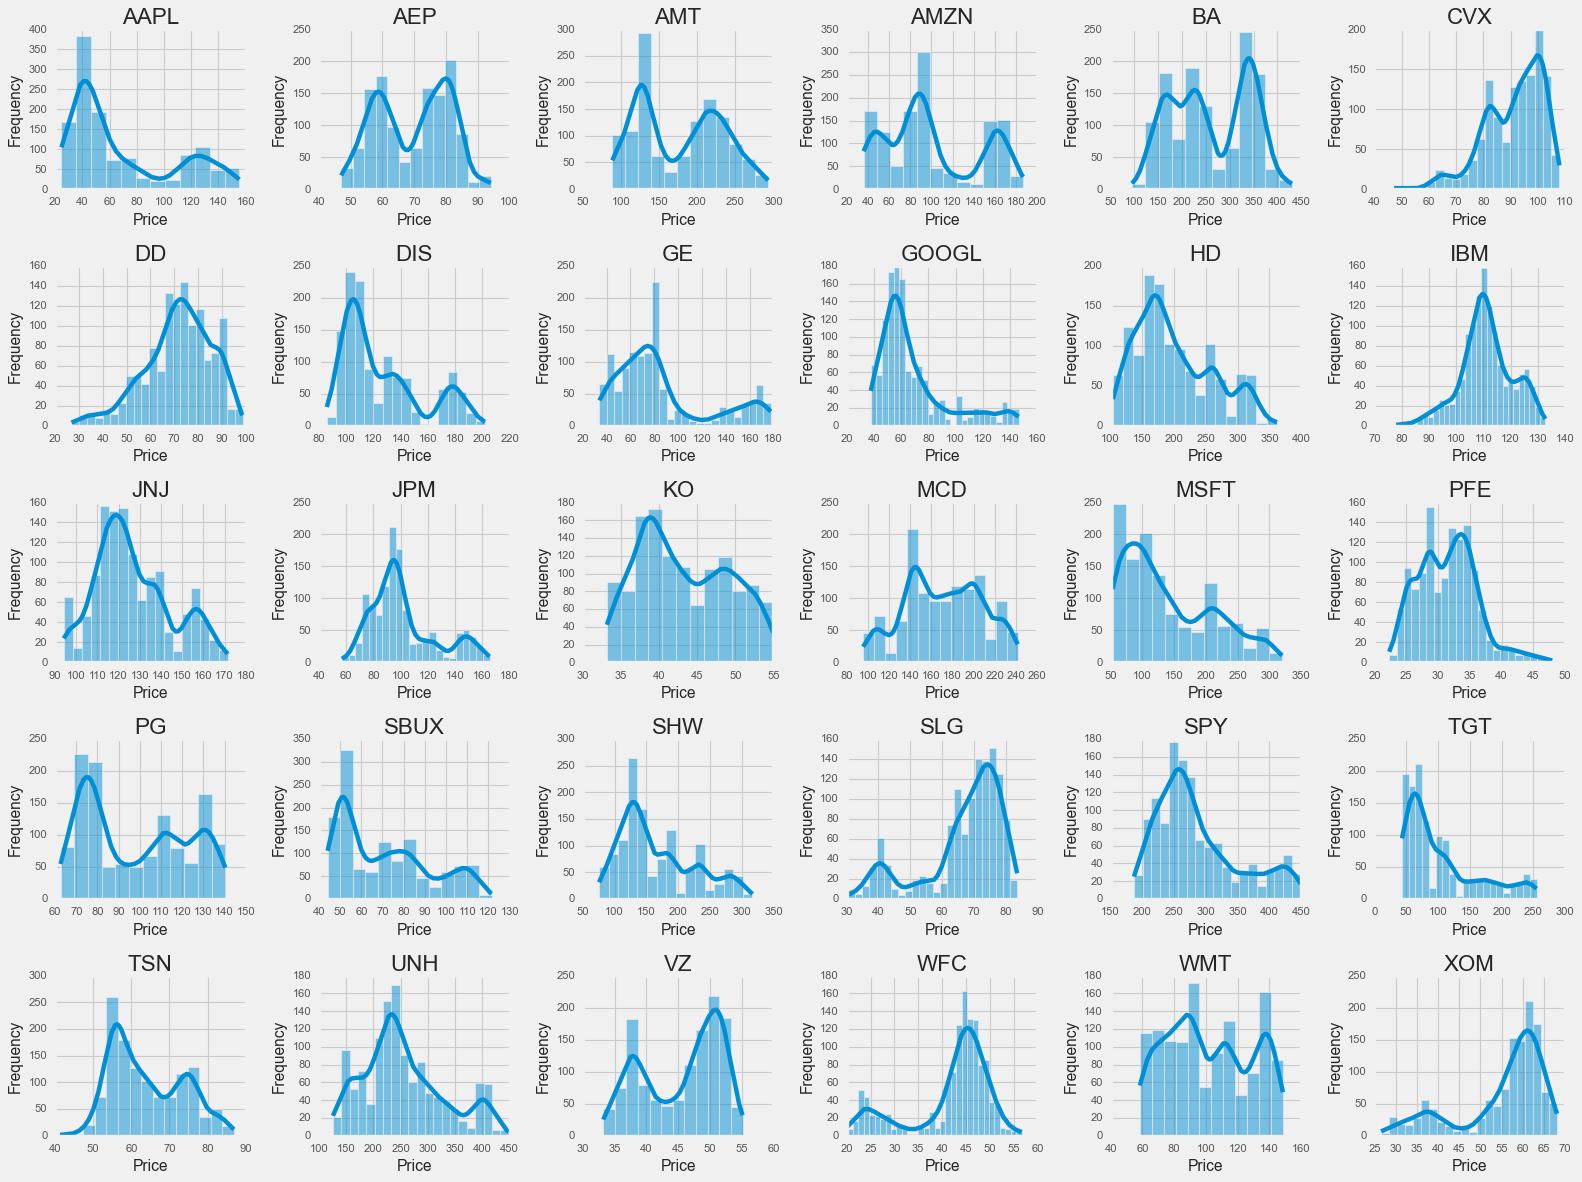

In [127]:
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(20, 15))

# Flatten the axes array
axes = axes.flatten()

for i, col in enumerate(in_sample_data.columns):
    ax = axes[i]
    sns.histplot(in_sample_data[col], kde=True, ax=ax)
    ax.set_title(col)
    ax.set_xlabel('Price')
    ax.set_ylabel('Frequency')

fig.tight_layout()

# display the plot
plt.show();

Next, we will apply PCA to the 30 dimensional data matrix to further explore the intrinsic dimensionality of the matrix. We build a pipeline as follows:

In [130]:
pca_pipeline = Pipeline([('power_transformer', PowerTransformer(method='yeo-johnson', standardize=True)), ('pca', PCA(n_components=30))])

pca_pipeline.fit(in_sample_data)

Pipeline(steps=[('power_transformer', PowerTransformer()),
                ('pca', PCA(n_components=30))])

We can plot the scree plot to examine the effectiveness of PCA:

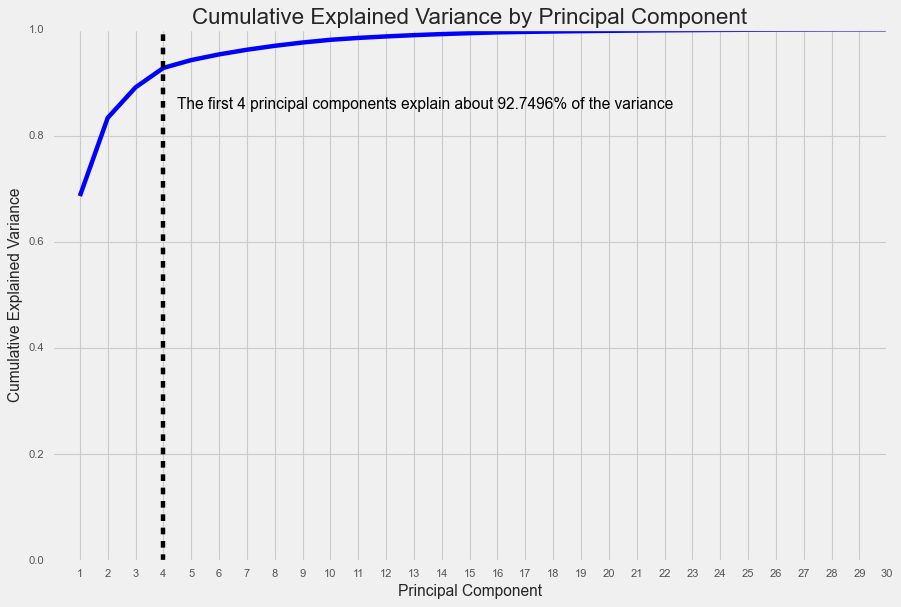

In [131]:
# Cumulative explained variance
cum_exp_var = np.cumsum(pca_pipeline['pca'].explained_variance_ratio_)
pc_indices = range(1, pca_pipeline['pca'].n_components + 1)
# Number of principal components that explain 90% of the variance
num_pc_90 = sum(cum_exp_var <= 0.90) + 1

plt.plot(pc_indices, cum_exp_var, color='blue')
plt.ylim(0, 1)
plt.xticks(pc_indices)
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Explained Variance')
plt.axvline(x=num_pc_90, color='black', linestyle='--')
plt.text(num_pc_90 + 0.5, 0.85, f'The first {num_pc_90} principal components explain about {round(cum_exp_var[num_pc_90 - 1] * 100, 4)}% of the variance', color='black')
plt.title('Cumulative Explained Variance by Principal Component')
plt.show();

On the other hand:

In [139]:
# First two principal components
cum_exp_var[:2]

array([0.68630516, 0.83348298])

We can plot the first two principal components and examine the factor loadings. These are the eigenvectors of the optimization problem:

In [140]:
pcs = pd.DataFrame(pca_pipeline.transform(in_sample_data), columns=[f'PC{i}' for i in range(1, pca_pipeline['pca'].n_components + 1)])
pcs

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30
0,8.146580,2.968783,-0.891631,1.636767,0.321646,-0.546398,-0.869622,-0.361657,0.714570,-0.017893,...,-0.174448,0.201626,0.024510,0.039376,0.322044,0.008559,0.012627,-0.160883,0.060639,0.067789
1,8.147167,2.927938,-0.940075,1.732925,0.412802,-0.524090,-0.693271,-0.376983,0.658848,-0.130232,...,-0.141658,0.116604,0.063950,0.005495,0.346513,-0.012565,-0.021330,-0.117332,0.056909,0.074487
2,8.325215,2.976313,-0.862420,1.768520,0.518499,-0.603699,-0.805306,-0.344297,0.725905,-0.121885,...,-0.176956,0.095267,0.118434,0.029019,0.383144,-0.014837,-0.030382,-0.104258,0.076525,0.069931
3,8.408600,3.149254,-0.848377,1.767289,0.577106,-0.622903,-0.856733,-0.320635,0.730896,-0.082454,...,-0.111587,0.037024,0.048523,0.047154,0.348774,-0.033506,-0.062286,-0.087462,0.103147,0.064597
4,8.475213,3.205090,-0.862901,1.839307,0.617924,-0.642856,-0.890278,-0.280596,0.698867,-0.044054,...,-0.199405,-0.018034,0.086499,0.055308,0.313189,-0.008201,-0.054216,-0.043883,0.117356,0.064276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1254,-7.069031,-2.847274,-0.759901,-0.505816,-0.076551,-0.209580,-0.144462,-0.225062,1.933402,-0.440144,...,0.138374,-0.142062,0.022798,-0.015148,-0.171982,-0.013604,-0.146192,-0.077089,-0.020653,0.006832
1255,-7.038279,-2.991826,-0.729472,-0.509228,-0.107533,-0.290048,-0.274215,-0.218411,2.065023,-0.498635,...,0.208053,-0.157288,0.038443,0.006720,-0.252080,0.004980,-0.146352,-0.080508,-0.031314,0.012328
1256,-7.071372,-3.063216,-0.706480,-0.561273,-0.262229,-0.267956,-0.362104,-0.262407,2.202424,-0.503807,...,0.161880,-0.090375,0.023762,0.067920,-0.278701,-0.029590,-0.205143,-0.042616,-0.020501,0.030166
1257,-7.178341,-2.557145,-0.665689,-0.571513,-0.137525,-0.157475,-0.271846,-0.220225,2.111124,-0.535213,...,0.140920,-0.073896,0.033161,0.041671,-0.196819,0.036798,-0.186961,-0.032064,0.002922,-0.018836


In [141]:
loadings = pd.DataFrame(pca_pipeline['pca'].components_.T[:, :2], columns=['PC ' + str(i) for i in range(1, 3)], index=in_sample_data.columns)
loadings

,PC 1,PC 2
AAPL,-0.212474,0.024586
AEP,-0.197737,-0.016440
AMT,-0.213707,0.043663
AMZN,-0.210596,0.026048
BA,-0.006836,-0.320684
CVX,-0.012479,-0.412646
DD,0.111173,-0.291164
DIS,-0.192814,-0.124370
GE,0.136013,-0.177791
GOOGL,-0.210097,-0.062712


These are the loadings--- how much each stock price series contributes to the first two principal components. To find out the top five stocks that contributed the most to each of the principal components:

In [151]:
loadings.apply(lambda col: np.abs(col)).sort_values(by='PC 1', ascending=False).iloc[:5, 0]

MSFT    0.218244
WMT     0.216568
SHW     0.216252
HD      0.214495
AMT     0.213707
Name: PC 1, dtype: float64

In [153]:
loadings.apply(lambda col: np.abs(col)).sort_values(by='PC 2', ascending=False).iloc[:5, 1]

CVX    0.412646
WFC    0.373185
BA     0.320684
XOM    0.311964
TSN    0.294763
Name: PC 2, dtype: float64

We plot the scatter plot of the first two principal components as follows:

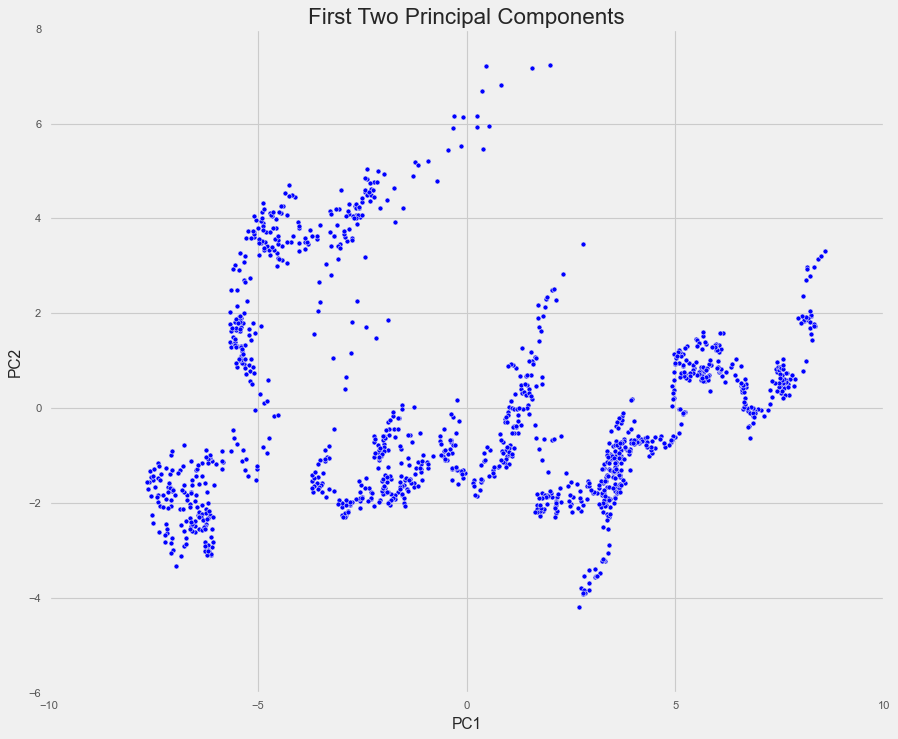

In [159]:
# Plot the first two principal components
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(pcs['PC1'], pcs['PC2'])
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('First Two Principal Components')
plt.show();

Using TSNE:

In [165]:
tsne_mapping = TSNE(n_components=2, perplexity=100, learning_rate='auto', random_state=seed).fit_transform(pcs)

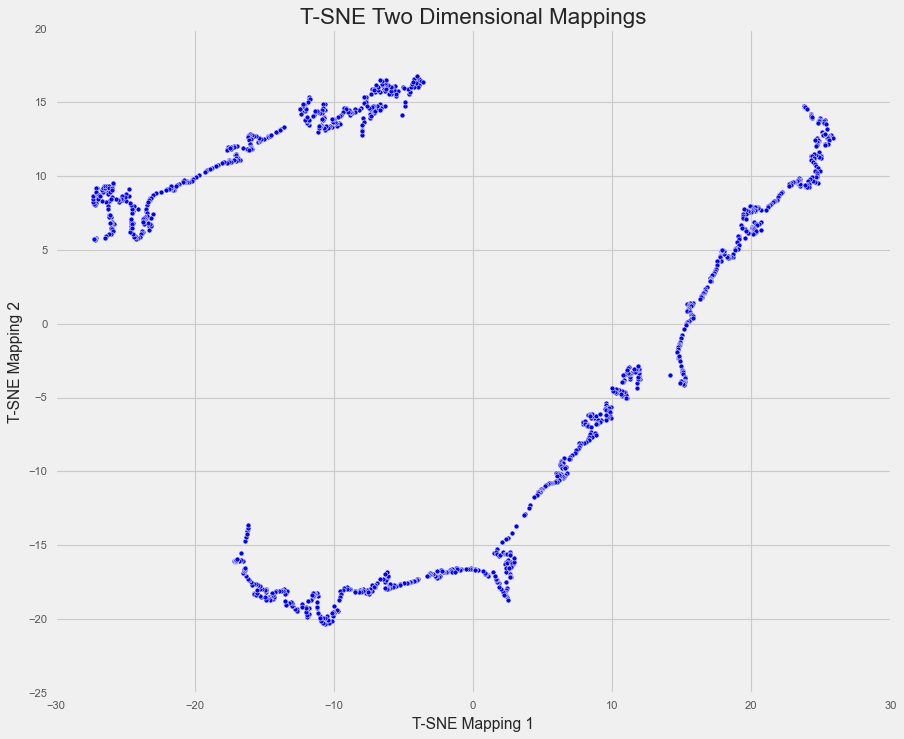

In [166]:
# Plot the first two t-SNE components
fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(tsne_mapping[:, 0], tsne_mapping[:, 1])
ax.set_xlabel('T-SNE Mapping 1')
ax.set_ylabel('T-SNE Mapping 2')
ax.set_title('T-SNE Two Dimensional Mappings')
plt.show();

## Exponentially Weighted Moving Expected Returns

The mean-variance optimization requires knowledge of the expected returns. For our purposes, we will use the exponentially-weighted mean of (daily) historical returns. The exponentially weighted moving average (EWMA) is an approach such that older observations are given lower weights compared to more recent observations, and the weights decrease exponentially over time. In `PyPortfolioOpt`'s implementation, the hyperparameter to tune is the `span`, which is the time-span for the EMA. This gives us the ability to decide exactly how much more weight is given to recent data. Generally, it is advisable to use a higher span – in the limit, this tends towards the mean historical return.

The EMA captures the intuition that recent prices are (exponentially) more relevant than previous prices. If we let $p_0$ denote today's price, $p_1$ denote yesterday's price, $p_n$ denote the price $n$ days ago, the exponentially weighted mean is given by:

$$
\alpha\left[p_0+(1-\alpha) p_1+(1-\alpha)^2 p_2+\ldots+(1-\alpha)^n p_n+\ldots\right]
$$

where $\alpha$ parametrizes the decay rate $(0<|\alpha|<1)$: by observation we note that higher $\alpha$ gives more weight to recent results, and lower $\alpha$ causes the exponential mean to tend to the arithmetic mean. Additionally, because $\frac{1}{\alpha}=1+(1-\alpha)+(1-\alpha)^2+\ldots$, we note that the 'weights' sum to one.

In practice, we do not compute the infinite sum above. Rather, observing that the weights rapidly become negligible, we limit the calculation to some window. This window is not to be confused with the `span` of the EMA, which is another way of specifying the decay rate - a good explanation can be found on the [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/window.html#exponentially-weighted-window).

The EMA is useful because it 'reacts' to recent data much better than the SMA owing to the exponential weighting scheme, while still preserving the memory of the time series.

In [175]:
in_sample_returns = ema_historical_return(in_sample_data, returns_data=False, span=500, frequency=252)
in_sample_returns

AAPL     0.521375
AEP      0.060583
AMT      0.261443
AMZN     0.276456
BA       0.039633
CVX      0.273810
DD       0.087241
DIS      0.165093
GE       0.310038
GOOGL    0.609656
HD       0.432851
IBM      0.023420
JNJ      0.098455
JPM      0.402083
KO       0.137653
MCD      0.199309
MSFT     0.587650
PFE      0.203442
PG       0.161381
SBUX     0.237081
SHW      0.450783
SLG      0.204265
SPY      0.289992
TGT      0.630663
TSN      0.213315
UNH      0.422291
VZ      -0.005521
WFC      0.448263
WMT      0.170840
XOM      0.323163
Name: 2021-10-28 00:00:00, dtype: float64

In [176]:
# Write the in-sample returns to disk
in_sample_returns.to_csv('../data/in_sample_returns.csv')

## Risk Model

In addition to the expected returns, mean-variance optimization requires a risk model, some way of quantifying asset risk. The most commonly-used risk model is the covariance matrix, which describes asset volatilities and their co-dependence. 

The easiest approach is to take two price series (e.g stock prices for AAPL and GOOG), then compute the daily percentage change or log returns, before feeding these into a covariance calculation. This does work and is the standard approach. But this may throw away a good deal of information, because covariance does not preserve the order of observations.

In other words, we will get the same covariance whether we provide $\left(x_2, y_2\right),\left(x_{17}, y_{17}\right),\left(x_8, y_8\right), \ldots$ or $\left(x_1, y_1\right),\left(x_2, y_2\right),\left(x_3, y_3\right), \ldots$.

However, in the case of time series, the order of the returns is of fundamental importance. Therefore, we need some way of incorporating the sequential nature of the data into the definition of covariance. Fortunately, it is simple to apply our intuition of the EMA to come up with a similar metric for covariance. We will rewrite the definition of covariance portfolio as follows:

$$
\operatorname{Cov}(x, y)=\frac{1}{N}\left[\left(x_1-\bar{x}\right)\left(y_1-\bar{y}\right)+\left(x_2-\bar{x}\right)\left(y_2-\bar{y}\right)+\ldots+\left(x_N-\bar{x}\right)\left(y_N-\bar{y}\right)\right]
$$

Rather than letting $\left(x_i, y_i\right)$ be any observations from the dataset, we will preserve the order by saying that $\left(x_i, y_i\right)$ denotes the returns of asset $X$ and $Y$ $i$ days ago. Thus $\left(x_1-\bar{x}\right)\left(y_1-\bar{y}\right)$ specifically refers to the co-variation of the returns yesterday. We simply give each co-variation term an exponential weight as follows:

$$
\operatorname{Cov}(x, y)=\frac{\alpha}{N}\left[\left(x_1-\bar{x}\right)\left(y_1-\bar{y}\right)+(1-\alpha)\left(x_2-\bar{x}\right)\left(y_2-\bar{y}\right)+\ldots+(1-\alpha)^N\left(x_N-\bar{x}\right)\left(y_N-\bar{y}\right)\right]
$$

Or more simply:

$$
\operatorname{Cov}(x, y)=\frac{\alpha}{N} \sum_{i=1}^N(1-\alpha)^{i-1}\left(x_i-\bar{x}\right)\left(y_i-\bar{y}\right)
$$

This simple procedure is all that is required to incorporate the temporal nature of asset returns into the covariance matrix.

In [180]:
in_sample_cov = exp_cov(in_sample_data, returns_data=False, span=500, frequency=252)
in_sample_cov.style.background_gradient(cmap='coolwarm')

,AAPL,AEP,AMT,AMZN,BA,CVX,DD,DIS,GE,GOOGL,HD,IBM,JNJ,JPM,KO,MCD,MSFT,PFE,PG,SBUX,SHW,SLG,SPY,TGT,TSN,UNH,VZ,WFC,WMT,XOM
AAPL,0.095714,0.021830,0.038438,0.056956,0.054316,0.035026,0.036938,0.033291,0.033291,0.054275,0.043035,0.029172,0.024716,0.034814,0.025820,0.032177,0.063372,0.024202,0.025548,0.042570,0.038213,0.032912,0.044638,0.030750,0.017275,0.039239,0.014611,0.034887,0.026007,0.028608
AEP,0.021830,0.051296,0.033070,0.010411,0.031952,0.019889,0.022170,0.019649,0.023557,0.017293,0.024674,0.024283,0.021454,0.024537,0.027531,0.020255,0.020589,0.021753,0.026188,0.022898,0.022812,0.036622,0.020981,0.018177,0.013622,0.026930,0.020990,0.029149,0.016900,0.018192
AMT,0.038438,0.033070,0.070126,0.026953,0.032994,0.025128,0.022267,0.020084,0.019616,0.030334,0.032166,0.023353,0.026789,0.025505,0.029834,0.028974,0.039977,0.024673,0.029919,0.035307,0.033017,0.038047,0.030120,0.023168,0.015685,0.035387,0.018030,0.026352,0.021104,0.015527
AMZN,0.056956,0.010411,0.026953,0.080966,0.027594,0.013394,0.015042,0.022969,0.009557,0.048888,0.027581,0.016595,0.013488,0.014015,0.012209,0.019594,0.052674,0.011767,0.015187,0.028995,0.023014,0.009056,0.031192,0.022405,0.008059,0.023792,0.008183,0.013129,0.017111,0.012619
BA,0.054316,0.031952,0.032994,0.027594,0.252050,0.111366,0.090736,0.084193,0.131598,0.052987,0.056034,0.067780,0.028160,0.102369,0.049523,0.053936,0.046183,0.036328,0.021633,0.071547,0.040727,0.145293,0.058776,0.030534,0.065756,0.051050,0.024373,0.118297,0.016748,0.104827
CVX,0.035026,0.019889,0.025128,0.013394,0.111366,0.128603,0.076321,0.059950,0.089407,0.039955,0.040758,0.055709,0.028862,0.083278,0.037707,0.040516,0.033787,0.029415,0.019304,0.048931,0.035802,0.100840,0.044899,0.025406,0.044906,0.049068,0.024436,0.092333,0.014528,0.111684
DD,0.036938,0.022170,0.022267,0.015042,0.090736,0.076321,0.115503,0.052369,0.080504,0.031144,0.041199,0.050574,0.025168,0.074348,0.031249,0.035092,0.030286,0.025536,0.018876,0.044526,0.038257,0.084837,0.041706,0.029943,0.036108,0.040195,0.022552,0.079326,0.016162,0.072415
DIS,0.033291,0.019649,0.020084,0.022969,0.084193,0.059950,0.052369,0.099892,0.063843,0.036953,0.035395,0.037533,0.020296,0.061115,0.032787,0.034547,0.034068,0.019809,0.019004,0.045972,0.029677,0.081859,0.037170,0.022352,0.035494,0.033270,0.018808,0.062810,0.013808,0.057915
GE,0.033291,0.023557,0.019616,0.009557,0.131598,0.089407,0.080504,0.063843,0.177978,0.028555,0.038023,0.061329,0.025655,0.086436,0.037882,0.038251,0.025209,0.028799,0.017943,0.048501,0.033727,0.111234,0.043011,0.027560,0.047399,0.040967,0.022354,0.101161,0.012453,0.089510
GOOGL,0.054275,0.017293,0.030334,0.048888,0.052987,0.039955,0.031144,0.036953,0.028555,0.076736,0.036042,0.028386,0.020476,0.034505,0.025528,0.030432,0.058831,0.021486,0.020530,0.039385,0.032522,0.037160,0.039161,0.023435,0.018467,0.036315,0.014230,0.037668,0.018802,0.035103


In [181]:
# Write the in-sample covariance matrix to disk
in_sample_cov.to_csv('../data/in_sample_cov.csv')